<a href="https://colab.research.google.com/github/tedteske/Covid-19-Model/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Corona Virus Analysis and Predictions

Datasets used in this study (all open): 

For country-level case and population data
* https://covid.ourworldindata.org/data/ecdc/full_data.csv
* https://covid.ourworldindata.org/data/ecdc/locations.csv

For U.S. state-level case and population data
* https://github.com/nytimes/covid-19-data
* https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html


We forecast each day's new confirmed cases according to the formula:

$ c_t = contagious_{t-1} \times R_{0,t}/days_{contagious} \times (1 - immune_{t-1}) $

where
* $ c_t          => \text{new confirmed cases @ time t} $
* $ C_t          => \text{cumulative confirmed cases @ time t} $
* $ contagious_t => C_t - C_{t - days_{contagious}}$
* $ days_{contagious} => \text{number of days each case is assumed to be contagious} = 12 \text{, by default}$
* $ immune       => \text{fraction of the population that is immune} = prevalence/(1 - unreported)$
* $ prevalance   => \text{cumulative confirmed cases as a fraction of the total population} = C_t/population$
* $ unreported   => \text{fraction of all cases that are not reported} $
* $ R_{0,t}      => \text{depicts the average number of people infected from 1 other person} \geq 0$

We assume that the path of $R_0$ (basic reproduction number) follows a sigmoid curve from the most recent $R_0$ to some target. 

$R_{0,t}=f(x)   => \frac{R_{0,target}-R_{0,t-1}}{1 + e^{(-k \times (x - offset)}}$

where
* $R_{0,target} => \text{assumed target basic reproduction number}$
* $e            => \text{base of the natural logarithm} \approx 2.71828$
* $offset       => x \text{ value of the sigmoid's midpoint, default 0}$
* $k            => \text{logistic growth rate or steepness of the curve, default 1}$
* $x            => \text{real number in the closed interval -7 to 7}$

Our approach basically follows a sigmod logistic curve with an interval [-7 .. 7]. To generate a path for $R_0$, we evenly divide the closed interval [-7 .. 7] by the number of days we assume it will take to get from $R_{0,t-1}$ to $R_{0,target}$ and insert the results into the formula as $x$. Rather than merely guessing the number of days, we take the average daily rate of the progress towards $R_{0,target}$ over the last several days.

$r_\Delta       => \overline{\% \Delta (R_{0,target} - R_{0,t})}$

and calculate the number of days to get from $R_{0,t-1}$ to $R_{0,target}$:

$days           => \log_{1+r_\Delta}(2)=\ln(2)/\ln(1+r\Delta) \text{, rounded}$

This assumes that the recent daily percent progess holds true in the near future. Our approach differs from other research being conducted as our work has shown that adjusting the sigmoid's logistic growth rate (k) from its default value of 1 provides the best possible results, based on the data available for our study.

Please watch this video for a more detailed discussion on R0 

-> https://www.youtube.com/watch?v=-3xZVhFhP8w&feature=youtu.be


## Loading Functions and Data. Run these first.

Run imports and functions.

In [98]:
import pandas as pd
import math
from datetime import date
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='darkgrid') 
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [13, 13/1.6]


def load_df(covid_data, pop_data, case_start=10, contagious_days=14):
    '''
    [1] https://covid.ourworldindata.org/data/ecdc/locations.csv
    [2] https://covid.ourworldindata.org/data/ecdc/locations.csv
    '''
    try:
        population_cols = ['location', 'continent', 'population']
        latest_pops = pop_data[population_cols].groupby('location').max()
        covid_data = covid_data.merge(latest_pops, 
                                      left_on='location', right_on='location')
    except:
        population_cols = ['location', 'population']
        latest_pops = pop_data[population_cols].groupby('location').max()
        covid_data = covid_data.merge(latest_pops, 
                                      left_on='location', right_on='location')
        covid_data['continent'] = 'NA'
    covid_data.rename(columns={'continent': 'region'}, inplace=True) 
    df = munge_data(covid_data, case_start, contagious_days)
    df = order_columns(df)
    return df


def munge_data(df, case_start, contagious_days):
    '''
    Indexes dataframe by location and date, and creates all calculated fields.
    '''

    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['contagious_days'] = contagious_days

    df.set_index(['location', 'date'], inplace=True)
    df['day'] = df.index.get_level_values('date').day_name().str.slice(stop=3)
    df.index.names = ['location', None]
    
    df['source'] = 'actual'
    df['prevalence'] = df['total_cases']/df['population']       
    
    df['contagious'] = (df['total_cases'] 
                        - df['total_cases'].shift(contagious_days))
    df.loc[df['contagious'] < 0, 'contagious'] = df.loc[df['contagious'] < 0, 
                                                        'total_cases']
    
    df['R0'] = df['new_cases']/df['contagious'] * contagious_days
    
    np.seterr(divide = 'ignore') 
    df['growth'] = np.log(1 + df['total_cases'].pct_change())
    df['delta_days'] = np.log(2)/df['growth']
    df.loc[df.groupby('location').head(1).index,
           ['growth', 'delta_days']] = np.NaN
    np.seterr(divide = 'warn') 
    
    df['fatality'] = df['total_deaths']/df['total_cases']
    
    return df


def order_columns(df):
    '''
    Re-orders dataframe columns after each load and forecast.
    '''

    column_names = ['day', 'new_cases',  'total_cases', 'prevalence', 
                    'growth', 'delta_days', 'contagious', 'R0',  
                    'new_deaths', 'total_deaths', 'fatality', 
                    'source', 'population', 'region']
    return df.reindex(columns=column_names)
   

def create_repro_path(days, last, move=[]):
    '''
    [1] https://en.wikipedia.org/wiki/Logistic_function
    [2] https://en.wikipedia.org/wiki/Sigmoid_function
    [3] https://ibguides.com/biology/notes/populations/
    '''
    
    if isinstance(move, (int, float)):
        move = [move]

    move_full_spec = [last, None, 0, 1]
    move_full_spec[:len(move)] = move
    target, rate, offset, k = move_full_spec
    
    if rate:
        days_motion = int(round(np.log(2)/np.log(1 + rate)))
    else:
        days_motion = days
    
    L = target - last

    y = []
    for x in np.linspace(-7, 7, days_motion):
        fx = L / (1 + math.e**(-k * (x - offset)))
        fx += last
        y.append(fx)
    
    days_flat = max(days - days_motion, 0)
    flat_values = np.ones(days_flat) * y[-1]
    y = y + list(flat_values)
    return pd.Series(y)


def forecast(df, days, repro_move=[], unreported=0.0,
             contagious_days=12, replace=True):
    '''
    Forecasts reproduction numbers
    '''

    if replace:
        df = df[df['source'] != 'forecast']
    
    if days > 0:        
        
        last_repro = df.iloc[-1]['R0']
        new_repros = create_repro_path(days, last_repro, repro_move)

        for i in range(days):

            last = df.iloc[-1]
            R0_ = new_repros[i]  
            
            trans_rate = last['R0']/contagious_days

            # adjust for herd immunity
            immune = last['prevalence']/(1 - unreported)

            new_cases_ = last['contagious'] * trans_rate * (1 - immune)
            total_cases_ = last['total_cases'] + new_cases_
            prevalence_ = total_cases_/last['population']
            contagious_ = (total_cases_ 
                           - df.iloc[-contagious_days]['total_cases'])
                     
            growth_ = np.log(total_cases_/last['total_cases'])
            delta_days_ = np.log(2)/growth_
            total_deaths_ = total_cases_ * last['fatality']
            new_deaths_ = total_deaths_ - last['total_deaths']

            data = {'source': 'forecast',
                    'new_cases': new_cases_,
                    'total_cases': total_cases_,
                    'prevalence': prevalence_,
                    'R0': R0_,
                    'contagious': contagious_,
                    'growth': growth_,
                    'delta_days': delta_days_,
                    'new_deaths': new_deaths_,
                    'total_deaths': total_deaths_,
                    'fatality': last['fatality'],
                    'population': last['population'],
                    'region': last['region']}
            
            next_date = df.index[-1] + pd.Timedelta(days=1)
            df = df.append(pd.DataFrame(data, index=[next_date]))
        
        df['day'] = df.index.day_name().str.slice(stop=3)
        df = order_columns(df)
    return df


def plot_timeline(df, title=None, date_freq='MS',
                  left=[],
                  right=None,
                  left_ylabel=None,
                  right_ylabel=None,
                  left_yscale=1000):
    '''
    Lineplots the time series'.
    '''
    
    data = df.copy()
    
    fig, ax = plt.subplots()
    fig_width = 40
    fig.figsize = (fig_width, fig_width/1.6)
   
    for column in left:
        sns.lineplot(x=data.index, y=column, style='source', data=data, 
                     legend=False, ax=ax)
    b = min(len(ax.lines)-1, 2)
    
    # configure right axis
    if right:
        ax2 = ax.twinx()
        sns.lineplot(x=data.index, y=right, style='source', data=data,
                     legend=False, ax=ax2, color='g')
        
        yticks = np.arange(data[right].min(), data[right].max(), 0.5)
        yticks = (yticks * 2).round()/2  # limits yticks to multiples of 0.5
        
        ax2.set_yticks(yticks)
        if right_ylabel:        
            ax2.set_ylabel(right_ylabel)
        else:
            ax2.set_ylabel(right)
        handles = [ax.lines[a] for a in [0, b]] + [ax2.lines[0]]
        labels = left + [right]
    
    else:
        handles = [ax.lines[a] for a in [0, b]] 
        labels = left 
   
    ax.legend(handles, labels, loc=0)

    # configure xticks
    xticks = pd.date_range(start=data.index.min(), 
                           end=data.index.max(),
                           freq=date_freq)
    ax.set_xticks(xticks)

    # configure ylabels, yticks
    if left_ylabel:
        ax.set_ylabel(left_ylabel) 
    else:
        ax.set_ylabel(str(left) + ' (thousands)')
    ax.set_yticklabels(ax.get_yticks()/left_yscale)

    plt.title(title)
    plt.show()


def plot_cdr(df, title=None, date_freq='MS',
             left=['new_deaths', 'new_cases'],
             right='R0',
             left_ylabel='cases, deaths (thousands)',
             right_ylabel='reproduction number',
             left_yscale=1000):
    '''
    Lineplots time series of New Deaths, New Cases, and Reproduction Numbers,
    appropriately scaled, using plot_timeline().
    '''
    
    plot_timeline(df, title=title, date_freq=date_freq,
                  left=left,
                  right=right,
                  left_ylabel=left_ylabel,
                  right_ylabel=right_ylabel,
                  left_yscale=left_yscale)


def plot_growth(df, locations, column='total_cases', title=None, 
                start=10, ascending=True, rolling=1, logy=True,
                min_cases=10):
    '''
    Lineplots several user-defined time series.
    '''
    
    data = df.copy()
    
    # apply rolling mean to each location
    data = data.groupby(level=0).rolling(rolling).mean()
    
    # unless plotting total_cases itself, apply a total_cases threshold
    if column != 'total_cases':
        data = data[data['total_cases'] >= min_cases]
    
    if ascending:
        data = data[data[column] >= start]
    else:
        data = data[data[column] <= start]        

    # create column representing days since cutoff values
    data['days_since'] = data.groupby(level=0).cumcount()
    data.loc[data['days_since'] == 0, column] = start
    
    # move location to column, then pivot
    data.reset_index(level=1, inplace=True) 
    pivoted = data.pivot(index='days_since', columns='location', values=column)
    pivoted.index.name = "days since " + str(start) + " " + column

    pivoted[locations].plot(logy=logy, title=title or column)

Load country and U.S. state-level data from public sources.

In [99]:
'''
Load country-level data from https://covid.ourworldindata.org
'''

covid_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv')
pop_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/locations.csv')
df = load_df(covid_data, pop_data, case_start=1, contagious_days=12)

'''
Data Cleansing
We drop China as the data did not pass Benford's Law
Remove negative numbers
'''
df = df.drop("China", axis=0)
df = df[(df['new_cases'] >= 0) | (df['new_cases'].isnull())]
df = df[(df['new_deaths'] >= 0) | (df['new_deaths'].isnull())]
df

day  new_cases  total_cases  prevalence    growth  \
location                                                                    
Afghanistan 2019-12-31  Tue          0            0    0.000000       NaN   
            2020-01-01  Wed          0            0    0.000000       NaN   
            2020-01-02  Thu          0            0    0.000000       NaN   
            2020-01-03  Fri          0            0    0.000000       NaN   
            2020-01-04  Sat          0            0    0.000000       NaN   
...                     ...        ...          ...         ...       ...   
Zimbabwe    2020-06-25  Thu          5          530    0.000036  0.009479   
            2020-06-26  Fri         21          551    0.000037  0.038858   
            2020-06-27  Sat         10          561    0.000038  0.017986   
            2020-06-28  Sun          6          567    0.000038  0.010638   
            2020-06-29  Mon          0          567    0.000038  0.000000   

                        delta_days  contagious        R0  new_deaths  \
location                                                               
Afghanistan 2019-12-31         NaN         NaN       NaN           0   
            2020-01-01         NaN         NaN       NaN           0   
            2020-01-02         NaN         NaN       NaN           0   
            2020-01-03         NaN         NaN       NaN           0   
            2020-01-04         NaN         NaN       NaN           0   
...                            ...         ...       ...         ...   
Zimbabwe    2020-06-25   73.126480       187.0  0.320856           0   
            2020-06-26   17.838044       195.0  1.292308           0   
            2020-06-27   38.537944       178.0  0.674157           0   
            2020-06-28   65.155220       180.0  0.400000           0   
            2020-06-29         inf       173.0  0.000000           0   

                        total_deaths  fatality  source  population  region  
location                                                                    
Afghanistan 2019-12-31             0       NaN  actual  38928341.0    Asia  
            2020-01-01             0       NaN  actual  38928341.0    Asia  
            2020-01-02             0       NaN  actual  38928341.0    Asia  
            2020-01-03             0       NaN  actual  38928341.0    Asia  
            2020-01-04             0       NaN  actual  38928341.0    Asia  
...                              ...       ...     ...         ...     ...  
Zimbabwe    2020-06-25             6  0.011321  actual  14862927.0  Africa  
            2020-06-26             6  0.010889  actual  14862927.0  Africa  
            2020-06-27             6  0.010695  actual  14862927.0  Africa  
            2020-06-28             6  0.010582  actual  14862927.0  Africa  
            2020-06-29             6  0.010582  actual  14862927.0  Africa  

[26364 rows x 14 columns]

In [100]:
'''
Load US state-level data from 
https://github.com/nytimes/covid-19-data
https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
'''

covid_state_data =  pd.read_csv('https://raw.githubusercontent.com/nytimes/'
                                'covid-19-data/master/us-states.csv')

covid_state_data.rename({'state':'location', 'cases':'total_cases', 
                         'deaths':'total_deaths'}, axis='columns', inplace=True) 
covid_state_data.drop('fips', axis='columns', inplace=True) 

covid_state_data.set_index(['location','date'], inplace=True)
covid_state_data.sort_index(inplace=True)
covid_state_data['new_cases'] = np.nan 
covid_state_data['new_deaths'] = np.nan 

for idx in covid_state_data.index.levels[0]:
    covid_state_data.new_cases[idx] = covid_state_data.total_cases[idx].diff()
    covid_state_data.new_deaths[idx] = covid_state_data.total_deaths[idx].diff()

covid_state_data.reset_index(inplace=True)

pop_state_data = pd.read_csv('http://www2.census.gov/programs-surveys/popest/'
                            'datasets/2010-2019/national/totals/'
                            'nst-est2019-popchg2010_2019.csv')
pop_state_data = pop_state_data[['NAME', 'POPESTIMATE2019']]

pop_state_data.rename({'NAME':'location', 'POPESTIMATE2019':'population'}, 
                      axis='columns', inplace=True) 

df_states = load_df(covid_state_data, pop_state_data,  
                    case_start=10, contagious_days=12)

'''
Data Cleansing
'''
df_states = df_states[(df_states['new_cases'] >= 0) | (df_states['new_cases'].isnull())]
df_states = df_states[(df_states['new_deaths'] >= 0) | (df_states['new_deaths'].isnull())]
df_states

day  new_cases  total_cases  prevalence    growth  \
location                                                                 
Alabama  2020-03-13  Fri        NaN            6    0.000001       NaN   
         2020-03-14  Sat        6.0           12    0.000002  0.693147   
         2020-03-15  Sun       11.0           23    0.000005  0.650588   
         2020-03-16  Mon        6.0           29    0.000006  0.231802   
         2020-03-17  Tue       10.0           39    0.000008  0.296266   
...                  ...        ...          ...         ...       ...   
Wyoming  2020-06-24  Wed       28.0         1282    0.002215  0.022083   
         2020-06-25  Thu       44.0         1326    0.002291  0.033746   
         2020-06-26  Fri       42.0         1368    0.002364  0.031183   
         2020-06-27  Sat       24.0         1392    0.002405  0.017392   
         2020-06-28  Sun       25.0         1417    0.002448  0.017800   

                     delta_days  contagious        R0  new_deaths  \
location                                                            
Alabama  2020-03-13         NaN         NaN       NaN         NaN   
         2020-03-14    1.000000         NaN       NaN         0.0   
         2020-03-15    1.065417         NaN       NaN         0.0   
         2020-03-16    2.990260         NaN       NaN         0.0   
         2020-03-17    2.339612         NaN       NaN         0.0   
...                         ...         ...       ...         ...   
Wyoming  2020-06-24   31.388390       255.0  1.317647         0.0   
         2020-06-25   20.540413       276.0  1.913043         0.0   
         2020-06-26   22.228419       308.0  1.636364         0.0   
         2020-06-27   39.854958       313.0  0.920128         0.0   
         2020-06-28   38.939980       328.0  0.914634         0.0   

                     total_deaths  fatality  source  population region  
location                                                                
Alabama  2020-03-13             0  0.000000  actual     4903185     NA  
         2020-03-14             0  0.000000  actual     4903185     NA  
         2020-03-15             0  0.000000  actual     4903185     NA  
         2020-03-16             0  0.000000  actual     4903185     NA  
         2020-03-17             0  0.000000  actual     4903185     NA  
...                           ...       ...     ...         ...    ...  
Wyoming  2020-06-24            20  0.015601  actual      578759     NA  
         2020-06-25            20  0.015083  actual      578759     NA  
         2020-06-26            20  0.014620  actual      578759     NA  
         2020-06-27            20  0.014368  actual      578759     NA  
         2020-06-28            20  0.014114  actual      578759     NA  

[6180 rows x 14 columns]

## United States

This is the last one week.

In [101]:
US_Cov = df[df['total_cases']>100].loc['United States']
US_Cov[US_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-06-23,Tue,31390,2312302,0.006986,0.013668,50.712389,311838.0,1.207935,427,120402,0.052070,actual,331002647.0,North America
2020-06-24,Wed,34720,2347022,0.007091,0.014904,46.508317,323675.0,1.287217,826,121228,0.051652,actual,331002647.0,North America
2020-06-25,Thu,34339,2381361,0.007194,0.014525,47.721362,332375.0,1.239768,751,121979,0.051222,actual,331002647.0,North America
2020-06-26,Fri,40949,2422310,0.007318,0.017049,40.655087,347784.0,1.412911,2437,124416,0.051363,actual,331002647.0,North America
2020-06-27,Sat,45527,2467837,0.007456,0.018620,37.225094,373768.0,1.461666,623,125039,0.050667,actual,331002647.0,North America
2020-06-28,Sun,42486,2510323,0.007584,0.017069,40.607657,396297.0,1.286490,500,125539,0.050009,actual,331002647.0,North America
2020-06-29,Mon,38673,2548996,0.007701,0.015288,45.338924,411265.0,1.128411,265,125804,0.049354,actual,331002647.0,North America


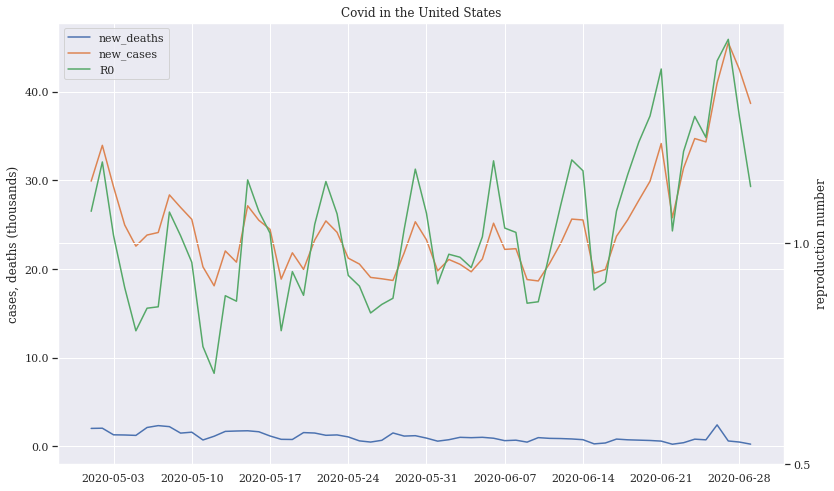

In [145]:
import warnings
warnings.filterwarnings('ignore')
plot_cdr(US_Cov[US_Cov['source']=='actual'][-60:],'Covid in the United States','W')

Now let's forecast the next 100 days. Start with estimating the daily percent change in the reproduction number. Assume a target of 0.7.

In [103]:
days_back = 14
target = 0.7
repros = US_Cov[US_Cov['source']=='actual'].R0 - target
repros.pct_change().tail(days_back).mean()

0.10791369033639532

Plug this estimate into forecast model, print the results, and plot.

In [104]:
US_Cov = forecast(US_Cov, 100, repro_move=[0.7, 0.03, -4])
default_scenario = US_Cov.copy()
default_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-10-01,Thu,308.435758,3.408944e+06,0.010299,0.000090,7660.568179,5062.513208,0.700007,15.222641,168246.170179,0.049354,forecast,331002647.0,North America
2020-10-02,Fri,292.274873,3.409236e+06,0.010300,0.000086,8084.859716,4797.260482,0.700007,14.425032,168260.595211,0.049354,forecast,331002647.0,North America
2020-10-03,Sat,276.960748,3.409513e+06,0.010301,0.000081,8532.612084,4545.905382,0.700007,13.669213,168274.264424,0.049354,forecast,331002647.0,North America
2020-10-04,Sun,262.449016,3.409776e+06,0.010301,0.000077,9005.122637,4307.719691,0.700007,12.952996,168287.217421,0.049354,forecast,331002647.0,North America
2020-10-05,Mon,248.697629,3.410025e+06,0.010302,0.000073,9503.760605,4082.013352,0.700007,12.274306,168299.491726,0.049354,forecast,331002647.0,North America
2020-10-06,Tue,235.666743,3.410260e+06,0.010303,0.000069,10029.970975,3868.132507,0.700007,11.631175,168311.122902,0.049354,forecast,331002647.0,North America
2020-10-07,Wed,223.318607,3.410484e+06,0.010303,0.000065,10585.278587,3665.457610,0.700007,11.021741,168322.144643,0.049354,forecast,331002647.0,North America


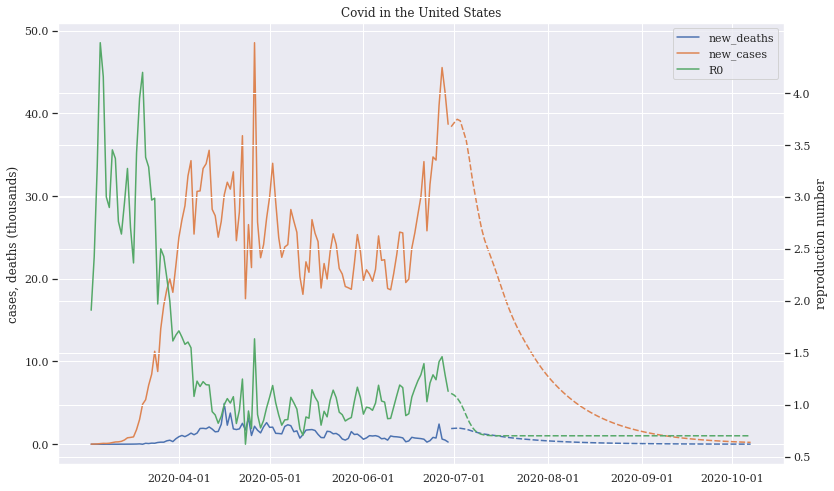

In [105]:
plot_cdr(default_scenario, 'Covid in the United States')

### Scenario: Relax on XYZ (Change Date Below) 

In [106]:
forecast_days = 100
relax_date = date(2020, 7, 1) 
relax_days = 7

last_actual = US_Cov[US_Cov['source']=='actual'].index.max().date()

stage_1 = (relax_date - last_actual).days # days until start of relation period
US_Cov = forecast(US_Cov, stage_1, repro_move=[0.7, 0.03, -4], replace=True)

stage_2 = relax_days # days during relation period
US_Cov = forecast(US_Cov, stage_2, repro_move=[1.0, None, 0], replace=False)

stage_3 = forecast_days - stage_1 - stage_2 # days during retrenchment
US_Cov = forecast(US_Cov, stage_3, repro_move=[0.7, 0.10,  0], replace=False)

relax_scenario = US_Cov.copy()
relax_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-10-01,Thu,432.504919,3.669251e+06,0.011085,0.000118,5880.121164,7101.456876,0.700273,21.345992,181093.456719,0.049354,forecast,331002647.0,North America
2020-10-02,Fri,409.819559,3.669661e+06,0.011087,0.000112,6206.324717,6728.983056,0.700273,20.226371,181113.683090,0.049354,forecast,331002647.0,North America
2020-10-03,Sat,388.323898,3.670049e+06,0.011088,0.000106,6550.588019,6376.042734,0.700273,19.165467,181132.848558,0.049354,forecast,331002647.0,North America
2020-10-04,Sun,367.955575,3.670417e+06,0.011089,0.000100,6913.910678,6041.612455,0.700273,18.160202,181151.008760,0.049354,forecast,331002647.0,North America
2020-10-05,Mon,348.655519,3.670766e+06,0.011090,0.000095,7297.347100,5724.722403,0.700273,17.207661,181168.216421,0.049354,forecast,331002647.0,North America
2020-10-06,Tue,330.367753,3.671096e+06,0.011091,0.000090,7702.009791,5424.453309,0.700273,16.305080,181184.521501,0.049354,forecast,331002647.0,North America
2020-10-07,Wed,313.039221,3.671410e+06,0.011092,0.000085,8129.072922,5139.933694,0.700273,15.449842,181199.971344,0.049354,forecast,331002647.0,North America


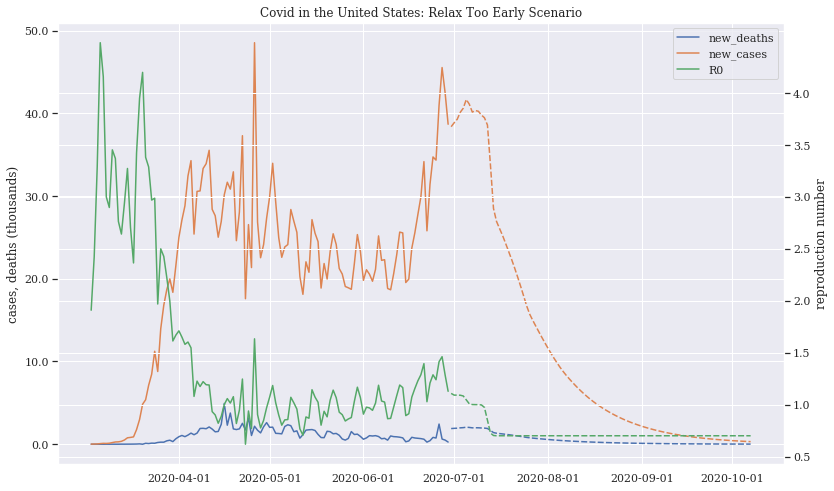

In [107]:
plot_cdr(relax_scenario, 'Covid in the United States: Relax Too Early Scenario')

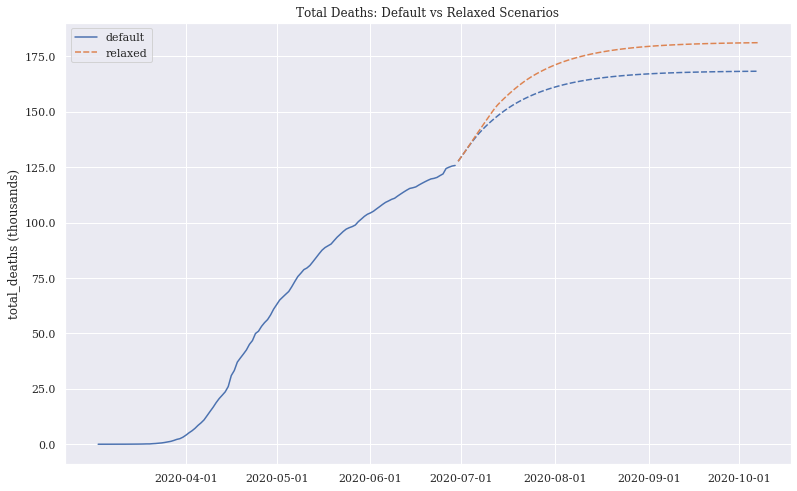

In [108]:
column = 'total_deaths'

relaxed = relax_scenario[relax_scenario['source']=='forecast'][column]
default = default_scenario[[column,'source']]

compare = pd.concat([default, relaxed], axis=1)
compare.columns = ['default','source','relaxed']

plot_timeline(compare, 'Total Deaths: Default vs Relaxed Scenarios',
              date_freq='MS',
              left=['default','relaxed'], right=None,
              left_ylabel=column + ' (thousands)')

### Scenario: No Further Improvements on Today's Reproduction Number

In [109]:
US_Cov = forecast(US_Cov, 100)
no_improvements_scenario = US_Cov.copy()
no_improvements_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-10-01,Thu,175787.461373,1.150096e+07,0.034746,0.015403,45.001952,1.962012e+06,1.128411,8675.873085,567622.263495,0.049354,forecast,331002647.0,North America
2020-10-02,Fri,178085.852755,1.167905e+07,0.035284,0.015366,45.109818,1.988590e+06,1.128411,8789.308661,576411.572157,0.049354,forecast,331002647.0,North America
2020-10-03,Sat,180397.661857,1.185944e+07,0.035829,0.015328,45.220429,2.015355e+06,1.128411,8903.406460,585314.978616,0.049354,forecast,331002647.0,North America
2020-10-04,Sun,182722.413549,1.204217e+07,0.036381,0.015290,45.333824,2.042303e+06,1.128411,9018.143031,594333.121648,0.049354,forecast,331002647.0,North America
2020-10-05,Mon,185059.613065,1.222723e+07,0.036940,0.015251,45.450045,2.069428e+06,1.128411,9133.493957,603466.615604,0.049354,forecast,331002647.0,North America
2020-10-06,Tue,187408.745846,1.241464e+07,0.037506,0.015211,45.569131,2.096727e+06,1.128411,9249.433841,612716.049445,0.049354,forecast,331002647.0,North America
2020-10-07,Wed,189769.277432,1.260440e+07,0.038079,0.015170,45.691127,2.124193e+06,1.128411,9365.936305,622081.985750,0.049354,forecast,331002647.0,North America


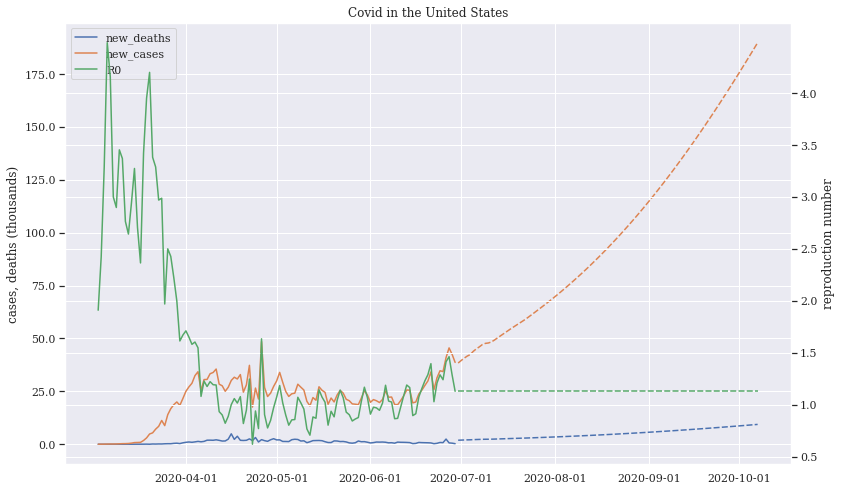

In [110]:
plot_cdr(US_Cov, 'Covid in the United States')

### Scenario: What if 90% of infections go unreported?

In [111]:
US_Cov = forecast(US_Cov, 100, repro_move=[0.7, 0.025, -4], unreported=0.9)
unreported_scenario = US_Cov.copy()
unreported_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-10-01,Thu,97.703148,3.260190e+06,0.009849,0.000030,23128.807787,1737.899293,0.700007,4.822074,160904.483122,0.049354,forecast,331002647.0,North America
2020-10-02,Fri,91.393285,3.260281e+06,0.009850,0.000028,24726.355625,1625.666907,0.700007,4.510655,160908.993776,0.049354,forecast,331002647.0,North America
2020-10-03,Sat,85.490905,3.260366e+06,0.009850,0.000026,26434.205633,1520.681826,0.700007,4.219347,160913.213123,0.049354,forecast,331002647.0,North America
2020-10-04,Sun,79.969699,3.260446e+06,0.009850,0.000025,28259.972693,1422.476124,0.700007,3.946851,160917.159974,0.049354,forecast,331002647.0,North America
2020-10-05,Mon,74.805052,3.260521e+06,0.009850,0.000023,30211.798517,1330.612045,0.700007,3.691953,160920.851928,0.049354,forecast,331002647.0,North America
2020-10-06,Tue,69.973936,3.260591e+06,0.009851,0.000021,32298.387882,1244.680086,0.700007,3.453517,160924.305445,0.049354,forecast,331002647.0,North America
2020-10-07,Wed,65.454811,3.260657e+06,0.009851,0.000020,34529.047061,1164.297200,0.700007,3.230479,160927.535923,0.049354,forecast,331002647.0,North America


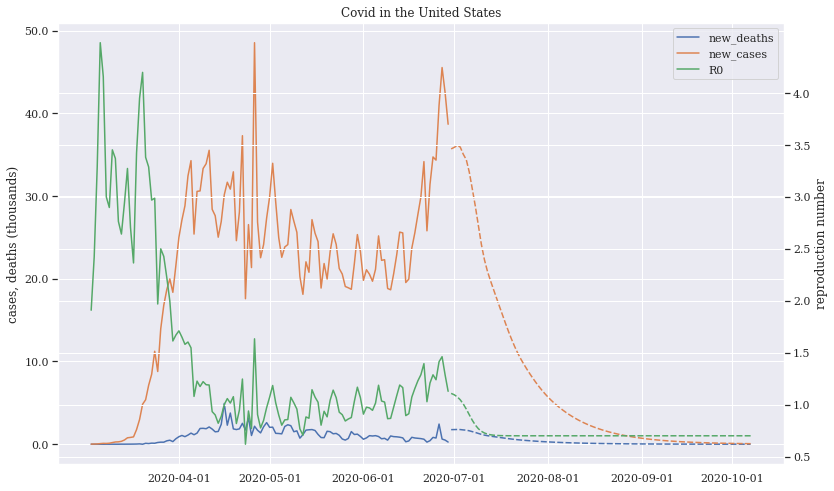

In [112]:
plot_cdr(unreported_scenario, 'Covid in the United States')

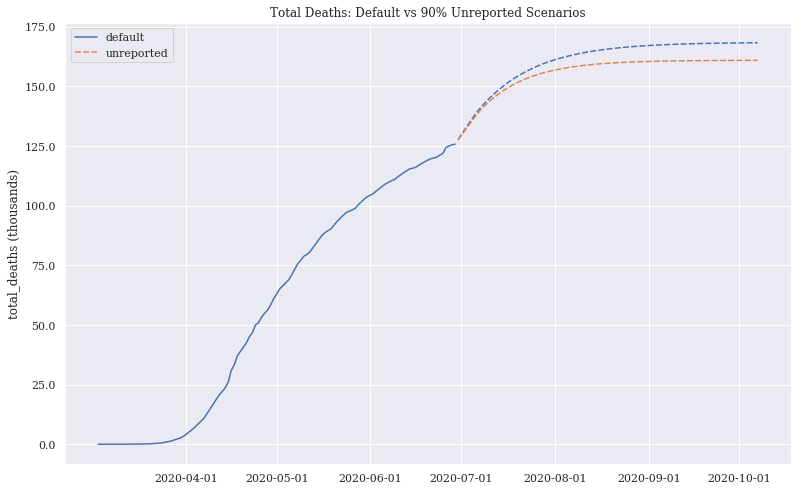

In [113]:
column = 'total_deaths'

unreported = unreported_scenario[unreported_scenario['source']=='forecast'][column]
default = default_scenario[[column,'source']]

compare = pd.concat([default, unreported], axis=1)
compare.columns = ['default','source','unreported']

plot_timeline(compare, 'Total Deaths: Default vs 90% Unreported Scenarios',
              date_freq='MS',
              left=['default','unreported'], right=None,
              left_ylabel=column + ' (thousands)')

## Other Countries

### Switzerland

In [114]:
Swiss_Cov = df[df['total_cases']>100].loc['Switzerland']
Swiss_Cov[Swiss_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-06-23,Tue,18,31227,0.003608,0.000577,1202.148227,299.0,0.722408,0,1679,0.053768,actual,8654618.0,Europe
2020-06-24,Wed,22,31249,0.003611,0.000704,984.205942,288.0,0.916667,0,1679,0.053730,actual,8654618.0,Europe
2020-06-25,Thu,44,31293,0.003616,0.001407,492.622771,313.0,1.686901,2,1681,0.053718,actual,8654618.0,Europe
2020-06-26,Fri,52,31345,0.003622,0.001660,417.474453,334.0,1.868263,0,1681,0.053629,actual,8654618.0,Europe
2020-06-27,Sat,58,31403,0.003628,0.001849,374.944715,369.0,1.886179,0,1681,0.053530,actual,8654618.0,Europe
2020-06-28,Sun,69,31472,0.003636,0.002195,315.808779,424.0,1.952830,0,1681,0.053413,actual,8654618.0,Europe
2020-06-29,Mon,62,31534,0.003644,0.001968,352.196913,471.0,1.579618,0,1681,0.053308,actual,8654618.0,Europe


In [115]:
days_back = 21
target = 0.7
repros= Swiss_Cov[Swiss_Cov['source']=='actual'].R0-target
repros.pct_change().tail(days_back).mean()

2.535148463078501

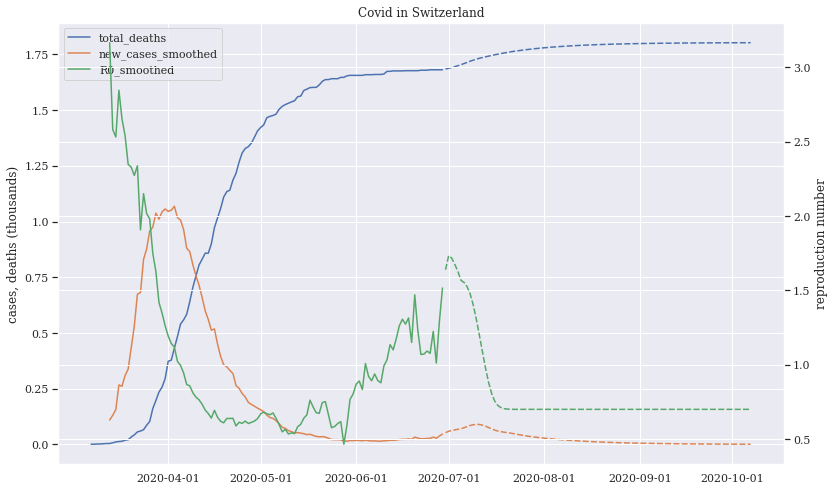

In [116]:
Swiss_Cov = forecast(Swiss_Cov, 100, repro_move=[0.7, 0.04])

Swiss_Cov['new_cases_smoothed']=Swiss_Cov['new_cases'].rolling(7).mean()
Swiss_Cov['R0_smoothed']=Swiss_Cov['R0'].rolling(7).mean()
plot_cdr(Swiss_Cov, 'Covid in Switzerland',
         left = ['total_deaths', 'new_cases_smoothed'],
         right='R0_smoothed')

### Italy

In [117]:
Italy_Cov = df[df['total_cases']>100].loc['Italy']
Italy_Cov[Italy_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-06-22,Mon,224,238499,0.003945,0.000940,737.666361,2938.0,0.914908,24,34634,0.145217,actual,60461828.0,Europe
2020-06-23,Tue,221,238720,0.003948,0.000926,748.377784,2957.0,0.896855,23,34657,0.145178,actual,60461828.0,Europe
2020-06-24,Wed,113,238833,0.003950,0.000473,1464.665971,2691.0,0.503902,18,34675,0.145185,actual,60461828.0,Europe
2020-06-26,Fri,296,239706,0.003965,0.001236,560.976119,3055.0,1.162684,34,34678,0.144669,actual,60461828.0,Europe
2020-06-27,Sat,255,239961,0.003969,0.001063,651.921171,2972.0,1.029610,30,34708,0.144640,actual,60461828.0,Europe
2020-06-28,Sun,175,240136,0.003972,0.000729,950.793906,2846.0,0.737878,8,34716,0.144568,actual,60461828.0,Europe
2020-06-29,Mon,174,240310,0.003975,0.000724,956.953379,2810.0,0.743060,22,34738,0.144555,actual,60461828.0,Europe


In [118]:
days_back = 21
target = 0.7
repros= Italy_Cov[Italy_Cov['source']=='actual'].R0-target
repros.pct_change().tail(days_back).mean()

0.9052290533826346

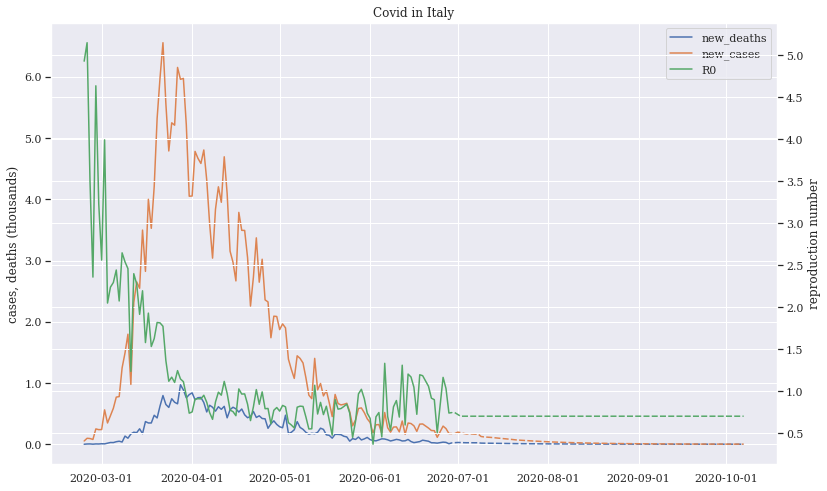

In [119]:
Italy_Cov = forecast(Italy_Cov, 100, repro_move=[0.7, 0.3])
plot_cdr(Italy_Cov, 'Covid in Italy')

### Spain

In [120]:
Spain_Cov = df[df['total_cases']>1000].loc['Spain']
Spain_Cov[Spain_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-06-22,Mon,232,246504,0.005272,0.000942,736.134202,4224.0,0.659091,1,28324,0.114903,actual,46754783.0,Europe
2020-06-23,Tue,248,246752,0.005278,0.001006,689.312453,4045.0,0.735723,1,28325,0.114791,actual,46754783.0,Europe
2020-06-24,Wed,334,247086,0.005285,0.001353,512.428690,3877.0,1.033789,2,28327,0.114644,actual,46754783.0,Europe
2020-06-25,Thu,400,247486,0.005293,0.001618,428.513891,3881.0,1.236795,3,28330,0.114471,actual,46754783.0,Europe
2020-06-26,Fri,419,247905,0.005302,0.001692,409.759896,3977.0,1.264270,8,28338,0.114310,actual,46754783.0,Europe
2020-06-27,Sat,564,248469,0.005314,0.002272,305.017811,4360.0,1.552294,3,28341,0.114063,actual,46754783.0,Europe
2020-06-28,Sun,301,248770,0.005321,0.001211,572.524533,4442.0,0.813147,2,28343,0.113933,actual,46754783.0,Europe


In [121]:
days_back = 14
target = 0.7
repros= Spain_Cov[Spain_Cov['source']=='actual'].R0-target
repros.pct_change().tail(days_back).mean()

2.152791943273353

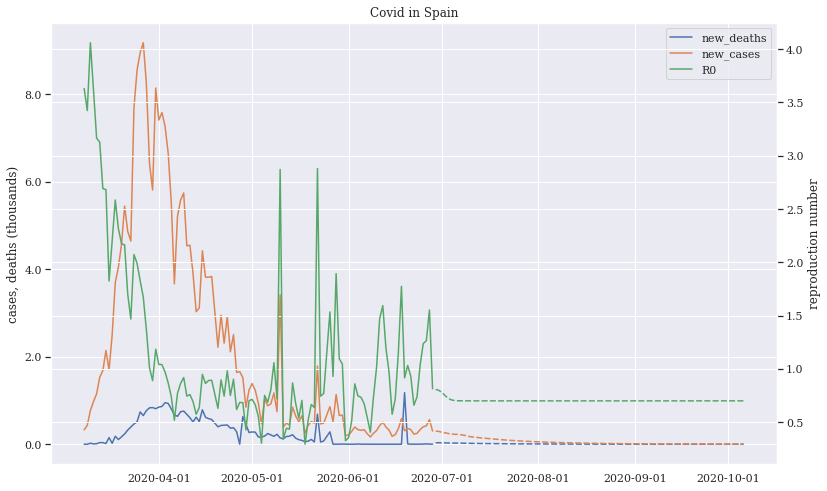

In [122]:
Spain_Cov = forecast(Spain_Cov, 100, repro_move=[0.7, 0.05,-4])
plot_cdr(Spain_Cov, 'Covid in Spain')

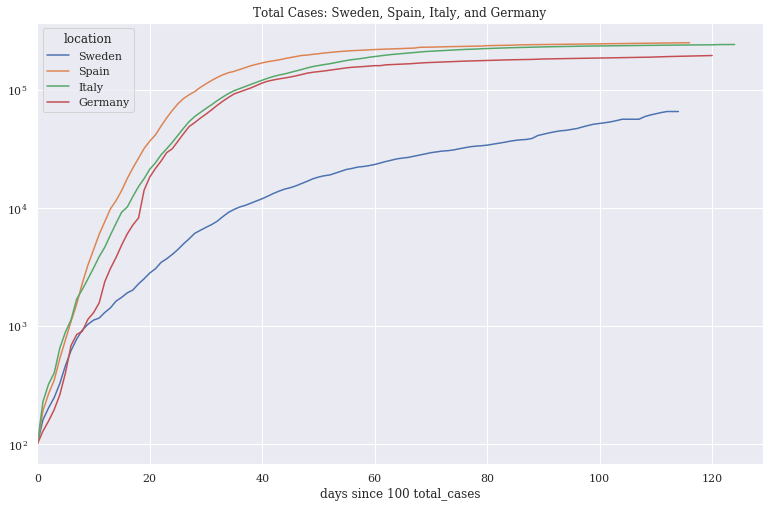

In [123]:
plot_growth(df[df['source']=='actual'], 
            ['Sweden','Spain','Italy','Germany'], 
            title='Total Cases: Sweden, Spain, Italy, and Germany',logy=True, 
            start=100, column='total_cases')

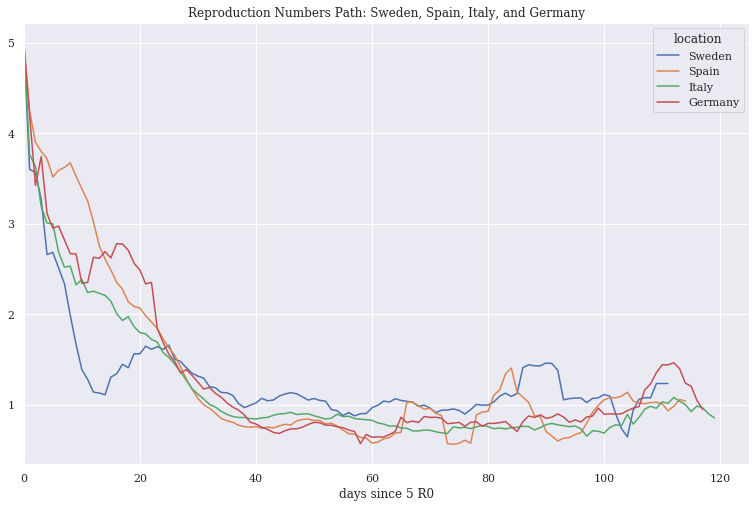

In [124]:
plot_growth(df[df['source']=='actual'],
            locations=['Sweden','Spain','Italy','Germany'], 
            column='R0', start=5, rolling=7, ascending=False, 
            logy=False, min_cases=100,
            title='Reproduction Numbers Path: Sweden, Spain, Italy, and Germany')

## The World, Country and Regional Comparisons

In [125]:
World_Cov = df.copy()
World_Cov = World_Cov[['new_cases','total_cases','new_deaths',
                       'total_deaths','population']].groupby(level=1).sum()
World_Cov['location']='world'
World_Cov.reset_index(inplace=True)
World_Cov.rename(columns = {'index':'date'}, inplace = True) 
World_Cov = munge_data(World_Cov, case_start=10, contagious_days=12)
World_Cov = order_columns(World_Cov).loc['world']
#World_Cov = World_Cov.drop("China")
World_Cov[World_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-06-23,Tue,136860,8978454,0.001423,0.015361,45.125213,1718800.0,0.955504,3435,467062,0.052020,actual,6.311159e+09,NaN
2020-06-24,Wed,165770,9144224,0.001449,0.018295,37.887835,1747048.0,1.138629,5576,472638,0.051687,actual,6.311159e+09,NaN
2020-06-25,Thu,170640,9076031,0.001452,-0.007485,-92.599383,1534423.0,1.334495,5225,443188,0.048831,actual,6.250698e+09,NaN
2020-06-26,Fri,181483,9496924,0.001505,0.045331,15.290807,1821351.0,1.195704,6715,484547,0.051021,actual,6.311159e+09,NaN
2020-06-27,Sat,189173,9686097,0.001535,0.019724,35.143033,1888494.0,1.202056,4701,489248,0.050510,actual,6.311159e+09,NaN
2020-06-28,Sun,181272,9867369,0.001563,0.018542,37.383163,1951040.0,1.114925,4625,493873,0.050051,actual,6.311159e+09,NaN
2020-06-29,Mon,159932,9778531,0.001561,-0.009044,-76.641794,1720899.0,1.115222,3041,468571,0.047918,actual,6.264405e+09,NaN


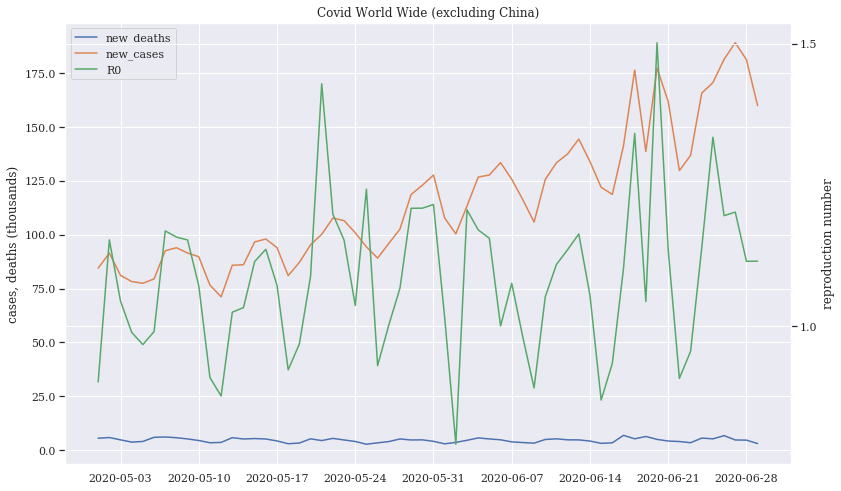

In [126]:
plot_cdr(World_Cov[World_Cov['source']=='actual'][-60:], 
         'Covid World Wide (excluding China)','W')

In [127]:
df[df['source']=='actual'].groupby('location')[['growth','delta_days']]\
    .last().sort_values('growth',ascending=False).head(10)

,growth,delta_days
location,,
Turks and Caicos Islands,0.559616,1.238613
Namibia,0.413696,1.675500
Suriname,0.225698,3.071129
Burundi,0.165985,4.175959
Lesotho,0.117783,5.884949
Malawi,0.098982,7.002772
Comoros,0.096414,7.189300
Paraguay,0.090994,7.617490
Palestine,0.090739,7.638929


In [128]:
df[df['source']=='actual'].groupby('location')[['region','total_cases']]\
    .last().groupby('region').sum()\
    .sort_values('total_cases',ascending=False)

,total_cases
region,
North America,2995671
Europe,2368592
South America,2140909
Asia,2130140
Africa,382730
Oceania,9259


In [129]:
top5 = df[df['source']=='actual']\
    .groupby('location')[['total_cases','R0']]\
    .last().sort_values('total_cases', ascending=False).head(5).reset_index()
top5.index += 1
top5

,location,total_cases,R0
1,United States,2548996,1.128411
2,Brazil,1344143,0.868770
3,Russia,634437,0.915857
4,India,548318,1.202082
5,United Kingdom,311151,0.830734


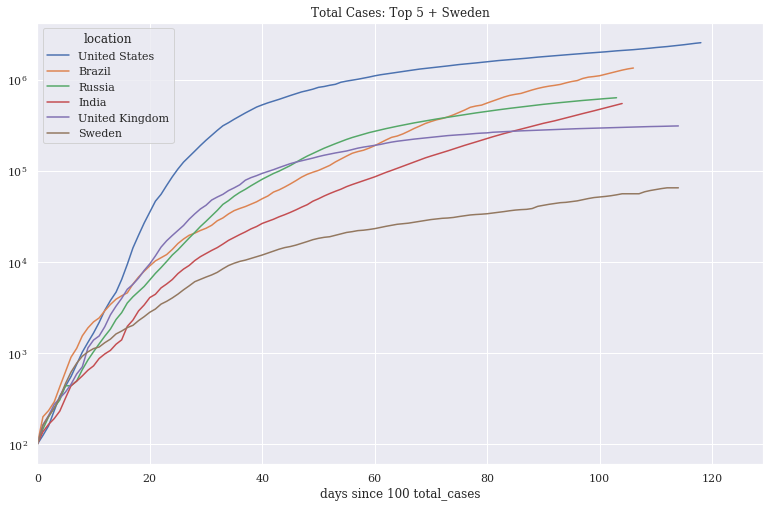

In [130]:
plot_growth(df[df['source']=='actual'], 
            locations=top5['location'].append(pd.Series('Sweden', index=[6])), 
            title='Total Cases: Top 5 + Sweden', 
            start=100, rolling=1, ascending=True, logy=True)

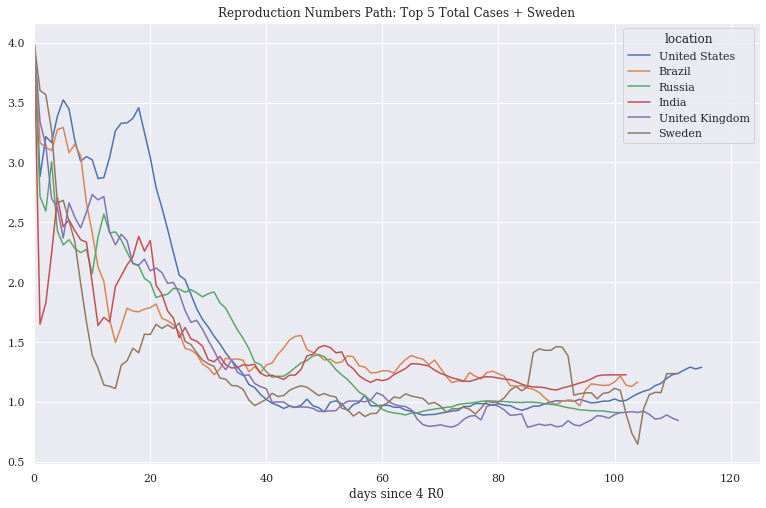

In [131]:
plot_growth(df[df['source']=='actual'],
            locations=top5['location'].append(pd.Series('Sweden', index=[6])), 
            column='R0', start=4, rolling=7, ascending=False, 
            logy=False, min_cases=100,
            title='Reproduction Numbers Path: Top 5 Total Cases + Sweden')

## U.S. States

### Texas

In [132]:
TX_Cov = df_states[df_states['total_cases']>10].loc['Texas']
TX_Cov[TX_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-06-22,Mon,4760.0,119646,0.004126,0.040597,17.073831,37875.0,1.508119,18.0,2213,0.018496,actual,28995881,NA
2020-06-23,Tue,5080.0,124726,0.004302,0.041582,16.669425,40954.0,1.488499,33.0,2246,0.018007,actual,28995881,NA
2020-06-24,Wed,6584.0,131310,0.004529,0.051442,13.474446,45279.0,1.744915,46.0,2292,0.017455,actual,28995881,NA
2020-06-25,Thu,5473.0,136783,0.004717,0.040835,16.974428,48663.0,1.349609,29.0,2321,0.016968,actual,28995881,NA
2020-06-26,Fri,5799.0,142582,0.004917,0.041522,16.693675,53040.0,1.311991,41.0,2362,0.016566,actual,28995881,NA
2020-06-27,Sat,6057.0,148639,0.005126,0.041603,16.660880,56912.0,1.277130,36.0,2398,0.016133,actual,28995881,NA
2020-06-28,Sun,3657.0,152296,0.005252,0.024305,28.518181,56323.0,0.779149,9.0,2407,0.015805,actual,28995881,NA


In [133]:
days_back = 21
target = 0.7
repros= TX_Cov[TX_Cov['source']=='actual'].R0-target
repros.pct_change().tail(days_back).mean()

0.17386909953252508

In [134]:
TX_Cov = forecast(TX_Cov, 50, repro_move=(0.7, 0.3))
TX_Cov.tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-08-11,Tue,410.990884,222440.990502,0.007671,0.001849,374.806033,6729.757354,0.700072,6.495608,3515.623944,0.015805,forecast,28995881,NA
2020-08-12,Wed,389.597726,222830.588228,0.007685,0.001750,396.099156,6380.105737,0.700072,6.157494,3521.781438,0.015805,forecast,28995881,NA
2020-08-13,Thu,369.350766,223199.938993,0.007698,0.001656,418.524558,6048.845187,0.700072,5.837496,3527.618934,0.015805,forecast,28995881,NA
2020-08-14,Fri,350.169263,223550.108256,0.007710,0.001568,442.162556,5734.777665,0.700072,5.534337,3533.153271,0.015805,forecast,28995881,NA
2020-08-15,Sat,331.983770,223882.092026,0.007721,0.001484,467.095593,5436.776214,0.700072,5.246920,3538.400191,0.015805,forecast,28995881,NA
2020-08-16,Sun,314.728965,224196.820990,0.007732,0.001405,493.415953,5153.906824,0.700072,4.974212,3543.374403,0.015805,forecast,28995881,NA
2020-08-17,Mon,298.350705,224495.171695,0.007742,0.001330,521.214696,4885.562702,0.700072,4.715358,3548.089761,0.015805,forecast,28995881,NA


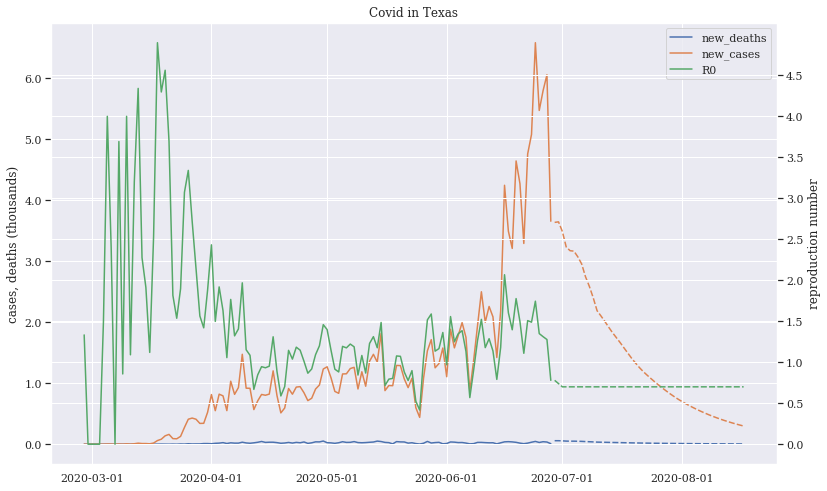

In [135]:
plot_cdr(TX_Cov, 'Covid in Texas')

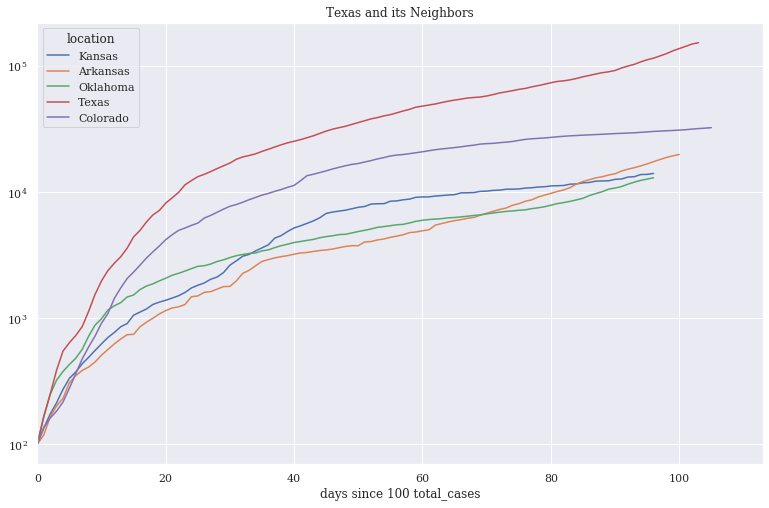

In [136]:
plot_growth(df_states, 
            ['Kansas', 'Arkansas','Oklahoma','Texas','Colorado'],
            title='Texas and its Neighbors', logy=True, 
            start=100, column='total_cases')

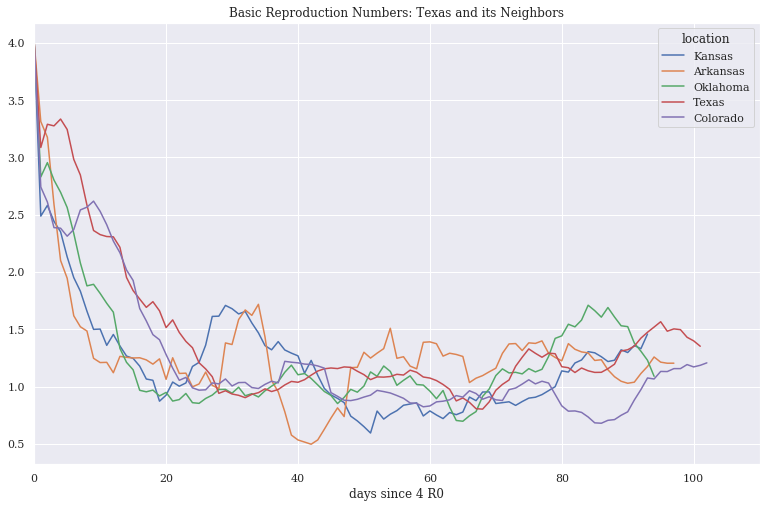

In [137]:
plot_growth(df_states[df_states['source']=='actual'],
            locations=['Kansas', 'Arkansas','Oklahoma','Texas','Colorado'], 
            column='R0', start=4, rolling=7, ascending=False, 
            logy=False, min_cases=100,
            title='Basic Reproduction Numbers: Texas and its Neighbors')

### New York

In [138]:
NY_Cov = df_states[df_states['total_cases']>10].loc['New York']
NY_Cov[NY_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-06-22,Mon,555.0,393257,0.020215,0.001412,490.797454,8312.0,0.801251,50.0,30934,0.078661,actual,19453561,NA
2020-06-23,Tue,598.0,393855,0.020246,0.001519,456.174213,8186.0,0.876619,36.0,30970,0.078633,actual,19453561,NA
2020-06-24,Wed,575.0,394430,0.020275,0.001459,475.128199,7940.0,0.869018,31.0,31001,0.078597,actual,19453561,NA
2020-06-25,Thu,738.0,395168,0.020313,0.001869,370.804518,7766.0,1.140355,28.0,31029,0.078521,actual,19453561,NA
2020-06-26,Fri,804.0,395972,0.020355,0.002033,341.030020,7876.0,1.224987,46.0,31075,0.078478,actual,19453561,NA
2020-06-27,Sat,697.0,396669,0.020391,0.001759,394.129650,7950.0,1.052075,30.0,31105,0.078416,actual,19453561,NA
2020-06-28,Sun,624.0,397293,0.020423,0.001572,440.971481,7944.0,0.942598,32.0,31137,0.078373,actual,19453561,NA


In [139]:
days_back = 21
target = 0.7
repros= NY_Cov[NY_Cov['source']=='actual'].R0-target
repros.pct_change().tail(days_back).mean()

0.08883946605143886

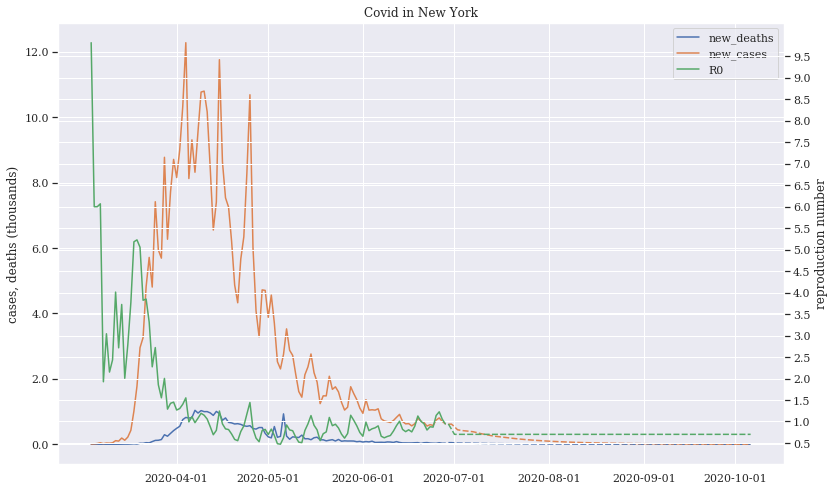

In [140]:
NY_Cov = forecast(NY_Cov, 100, repro_move=(0.7,0.3))
plot_cdr(NY_Cov, 'Covid in New York')

In [141]:
### Illinois

In [142]:
IL_Cov = df_states[df_states['total_cases']>10].loc['Illinois']
IL_Cov[IL_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,delta_days,contagious,R0,new_deaths,total_deaths,fatality,source,population,region
2020-06-22,Mon,461.0,138615,0.010939,0.003331,208.071014,7726.0,0.716024,24.0,6889,0.049699,actual,12671821,NA
2020-06-23,Tue,667.0,139282,0.010991,0.004800,144.395167,7551.0,1.059992,36.0,6925,0.049719,actual,12671821,NA
2020-06-24,Wed,743.0,140025,0.011050,0.005320,130.282909,7536.0,1.183121,61.0,6986,0.049891,actual,12671821,NA
2020-06-25,Thu,910.0,140935,0.011122,0.006478,107.003270,7818.0,1.396777,38.0,7024,0.049839,actual,12671821,NA
2020-06-26,Fri,877.0,141812,0.011191,0.006203,111.735837,8093.0,1.300383,35.0,7059,0.049777,actual,12671821,NA
2020-06-27,Sat,724.0,142536,0.011248,0.005092,136.115047,8289.0,1.048136,24.0,7083,0.049693,actual,12671821,NA
2020-06-28,Sun,581.0,143117,0.011294,0.004068,170.395266,8251.0,0.844988,15.0,7098,0.049596,actual,12671821,NA


In [143]:
days_back = 21
target = 0.7
repros= IL_Cov[IL_Cov['source']=='actual'].R0-target
repros.pct_change().tail(days_back).mean()

0.41612055387527613

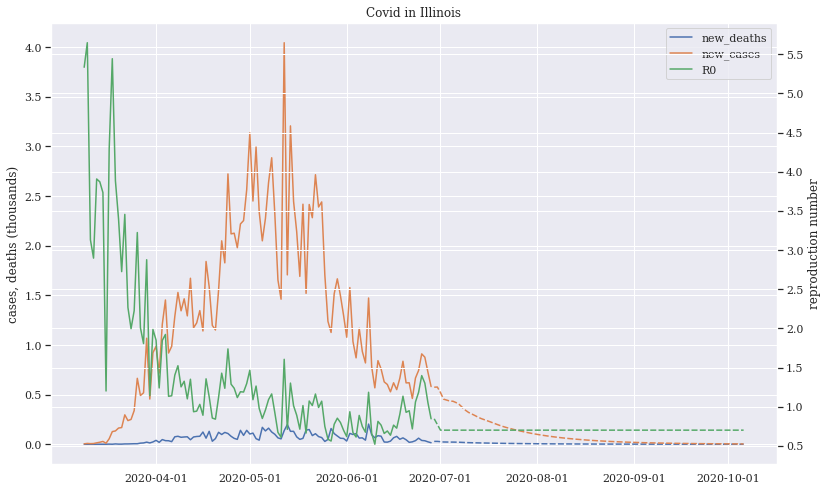

In [144]:
IL_Cov = forecast(IL_Cov, 100, repro_move=(0.7,0.3))
plot_cdr(IL_Cov, 'Covid in Illinois')